<a href="https://colab.research.google.com/github/david91107/predict_sklearn/blob/main/DTC_model_post_process_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Prepare Enviornment

#### Install Libraries

In [ ]:
# Install libraries

!pip install --upgrade pip
!pip install pandas==1.5.3 # to be compatible with google-colab 1.0.0
!pip install matplotlib
!pip install shap

#### Import Methods

In [ ]:
# Import necessary methods

import warnings
warnings.filterwarnings('ignore', category=FutureWarning) # Ignore FutureWarning

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import f_oneway

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score,f1_score

import shap as shap
from shap import TreeExplainer, summary_plot

from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

## Ingest Data

In [ ]:
# Load CSV data file into a dataframe

df_pre = pd.read_csv(r'/content/drive/MyDrive/Data_sets/telco_subscription_data.csv')

In [ ]:
# Check data load

df_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134575 entries, 0 to 134574
Data columns (total 15 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   random_key                 134575 non-null  int64  
 1   target                     134575 non-null  int64  
 2   customer_demo_age          134575 non-null  int64  
 3   customer_demo_geography_1  134575 non-null  int64  
 4   customer_demo_geography_2  134575 non-null  int64  
 5   sales_channel              134575 non-null  int64  
 6   sales_team                 134575 non-null  int64  
 7   sales_program              134575 non-null  int64  
 8   product_sku                134575 non-null  int64  
 9   product_cpe                134575 non-null  int64  
 10  product_operations_kpi1    132071 non-null  float64
 11  product_operations_kpi2    134575 non-null  int64  
 12  product_usage_kpi1         134575 non-null  int64  
 13  product_usage_kpi2         13

## Data Cleansing

In [ ]:
# Look for Null values

print('Null count')
print(df_pre.isnull().sum())

print()

# Look for NaN values
print('NaN count')
print(df_pre.isna().sum())

Null count
random_key                      0
target                          0
customer_demo_age               0
customer_demo_geography_1       0
customer_demo_geography_2       0
sales_channel                   0
sales_team                      0
sales_program                   0
product_sku                     0
product_cpe                     0
product_operations_kpi1      2504
product_operations_kpi2         0
product_usage_kpi1              0
product_usage_kpi2              0
product_usage_kpi3              0
dtype: int64

NaN count
random_key                      0
target                          0
customer_demo_age               0
customer_demo_geography_1       0
customer_demo_geography_2       0
sales_channel                   0
sales_team                      0
sales_program                   0
product_sku                     0
product_cpe                     0
product_operations_kpi1      2504
product_operations_kpi2         0
product_usage_kpi1              0
product_usage

In [ ]:
# Drop Nulls

df_pre.dropna(inplace=True)

In [ ]:
# Check for any duplication

print("Number of duplicate rows:", df_pre.duplicated().sum())

Number of duplicate rows: 0


In [ ]:
# Drop random_key

df_pre.drop(columns='random_key', inplace=True)

In [ ]:
# Some of the int values are actually string values
# that will need to be flattened

columns_to_cast = ['sales_team', 'sales_channel','sales_program','product_sku','product_cpe','customer_demo_geography_1','customer_demo_geography_2']

df_pre[columns_to_cast] = df_pre[columns_to_cast].astype(object)

In [ ]:
# Some of the float64 values are actually int values
# that will need to be flattened

# Define a list of column names to cast
columns_to_cast = ['product_operations_kpi1']

# Cast the columns
df_pre[columns_to_cast] = df_pre[columns_to_cast].astype(int)

In [ ]:
# Count distinct values for categorical features

features_categorical = ['product_sku','customer_demo_geography_2','customer_demo_geography_1','sales_channel','product_cpe','sales_program','sales_team']

for feature in features_categorical:
  unique_values = df_pre[feature].nunique()
  print(feature, unique_values)

product_sku 3
customer_demo_geography_2 5307
customer_demo_geography_1 50
sales_channel 4
product_cpe 18
sales_program 20
sales_team 22


In [ ]:
# Drop categories with a high unique value count until an ANOVA check

feature_high_count = ['customer_demo_geography_2']
df_pre.drop(columns=feature_high_count, inplace=True)

## Explority Data Analysis

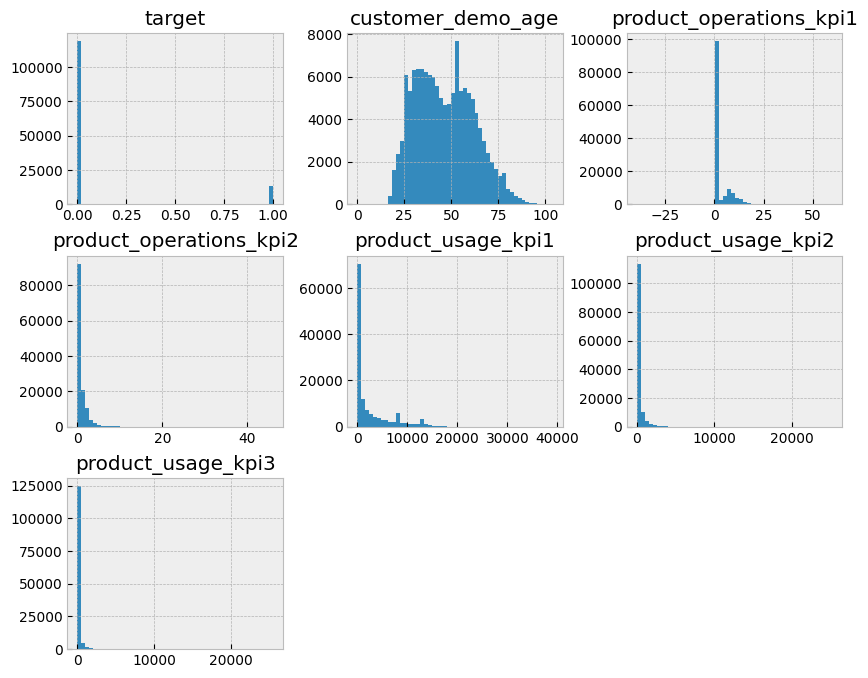

In [ ]:
# Exploratory plots

df_pre.hist(bins=50, figsize=(10, 8))
plt.show()

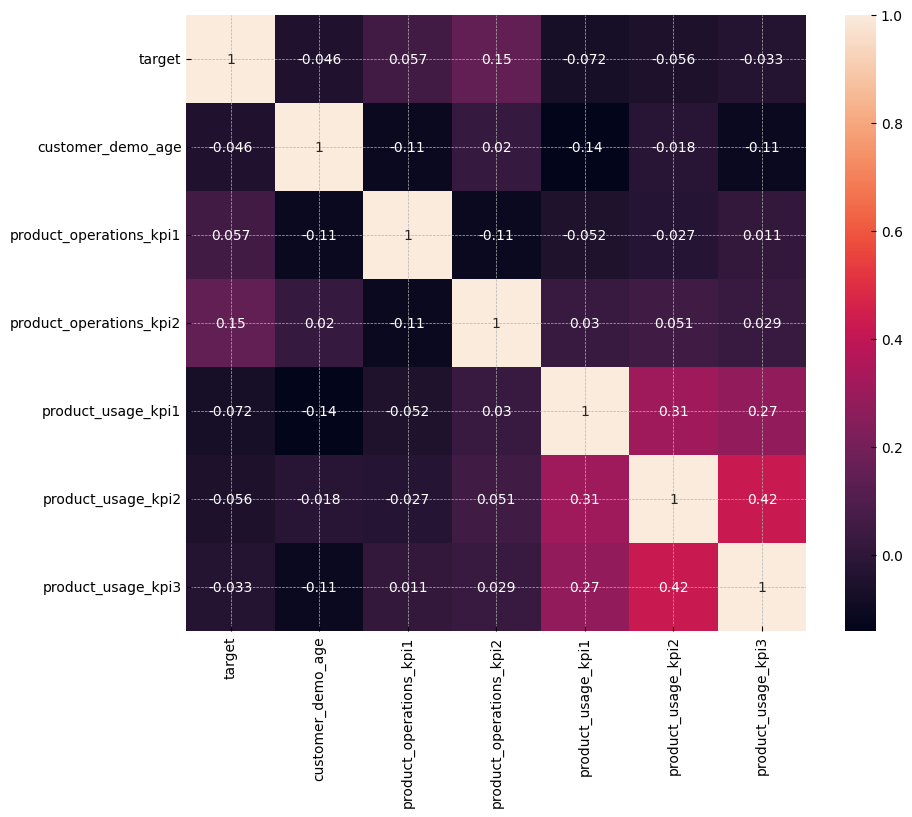

In [ ]:
# Collinearity: Pearson

df_num = df_pre.select_dtypes(include = ['float64', 'int64'])

plt.style.use('bmh')
plt.figure(figsize=(10, 8))

corrMatrix = df_num.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
# Collinearity: VIF

df_num = df_pre.select_dtypes(include = ['float64', 'int64'])

# Calculate VIF for each numeric feature
vif = pd.DataFrame()
vif["Feature"] = df_num.columns
vif["VIF"] = [variance_inflation_factor(df_num.values, i) for i in range(df_num.shape[1])]

# Print the VIF values to identify multicollinearity among numeric features
print("VIF Values for Numeric Features:")
print(vif)

VIF Values for Numeric Features:
                   Feature       VIF
0                   target  1.136787
1        customer_demo_age  1.996267
2  product_operations_kpi1  1.461237
3  product_operations_kpi2  1.245531
4       product_usage_kpi1  1.564750
5       product_usage_kpi2  1.536754
6       product_usage_kpi3  1.363380


## Prepare Dataset

In [ ]:
# Normalize continuous features

columns_to_norm = ['product_usage_kpi1','product_usage_kpi2', 'product_usage_kpi3','product_operations_kpi1','product_operations_kpi2']

for column in columns_to_norm:
  df_pre[column] = df_pre[column] / df_pre[column].abs().max()

In [ ]:
# Bin age into generations
# Assumption is that trends fall along generations more than specific age
# https://www.beresfordresearch.com/age-range-by-generation/

df_pre['customer_demo_age_gen'] = df_pre['customer_demo_age'].apply(lambda age:
    'gen_z' if age >= 12 and age <= 27 else
    'millennial' if age >= 28 and age <= 43 else
    'gen_x' if age >= 44 and age <= 59 else
    'boomers' if age >= 60 and age <= 78 else
    'post_war' if age >= 79 and age <= 96 else
    'invalid' if age < 18 and age > 99 else
    'other'
)

# Drop age
df_pre.drop('customer_demo_age', axis=1, inplace=True)

In [ ]:
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132071 entries, 0 to 134574
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   target                     132071 non-null  int64  
 1   customer_demo_geography_1  132071 non-null  object 
 2   sales_channel              132071 non-null  object 
 3   sales_team                 132071 non-null  object 
 4   sales_program              132071 non-null  object 
 5   product_sku                132071 non-null  object 
 6   product_cpe                132071 non-null  object 
 7   product_operations_kpi1    132071 non-null  float64
 8   product_operations_kpi2    132071 non-null  float64
 9   product_usage_kpi1         132071 non-null  float64
 10  product_usage_kpi2         132071 non-null  float64
 11  product_usage_kpi3         132071 non-null  float64
 12  customer_demo_age_gen      132071 non-null  object 
dtypes: float64(5), int64(1), obje

In [ ]:
# Flatten categorical features

categorical_features = ['product_sku','sales_channel','sales_team','product_cpe','sales_program','customer_demo_age_gen','customer_demo_geography_1']

# Perform one-hot encoding (flattening) of the specified columns
df_pre = pd.get_dummies(df_pre, columns=categorical_features)

# Convert boolean values to integers (1 and 0)
df_pre = df_pre.astype(int)

### Feature Reduction

In [ ]:
# Pre-reduction feature data

unique_column_names = set(df_pre.columns)
column_count = len(unique_column_names)
print(f"Total Features: {column_count}")

# For a list of features
#print()
#for column, dtype in df_pre.dtypes.items():
#    print(f'Column: {column}, Data Type: {dtype}')

Total Features: 129


In [ ]:
# Reduce features to those that are most
# statistically significant based on ANOVA

# Define the target variable (column 1)
target_variable = 'target'

# Perform ANOVA tests for each feature
alpha = 0.05

# Initialize a list to store ANOVA results
anova_results = []

for feature_column in df_pre.columns[2:]:
  f_statistic, p_value = f_oneway(df_pre[feature_column], df_pre[target_variable])
  if p_value >= alpha:
    significance = 'Not Significant'
    df_pre.drop(columns=feature_column, inplace=True)

  else:
    significance = 'Significant'

  anova_results.append([feature_column, f_statistic, p_value, significance])

# Create a DataFrame from the ANOVA results
df_anova = pd.DataFrame(anova_results, columns=['Feature', 'F-statistic', 'P-value', 'Significance'])
df_filtered_not_sig = df_anova[df_anova['Significance'] == 'Not Significant'][['Feature', 'Significance']]

In [ ]:
# Feature count after reduction

unique_column_names = set(df_pre.columns)
column_count = len(unique_column_names)
print(f"Total Features: {column_count}")

# For a list of features
#print()
#for column, dtype in df_pre.dtypes.items():
#    print(f'Column: {column}, Data Type: {dtype}')

Total Features: 127


The resuling feature set is still too large to be practical.

In [ ]:
# Additional feature reduction using Recursive Feature Elimination

from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
import pandas as pd

# Load your dataset into a DataFrame (replace 'your_dataset.csv' with your actual dataset file)
df_rfe = df_pre.copy()

# Extract the target variable and create X and y
y = df_rfe.pop('target')
X = df_rfe

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Decision Tree Classifier
clf = DecisionTreeClassifier()

# Specify the number of features to select (you can adjust this)
num_features_to_select = 12

# Create the RFE model
rfe = RFE(estimator=clf, n_features_to_select=num_features_to_select)

# Fit the RFE model to the training data
rfe.fit(X_train, y_train)

# Get the selected feature indices
selected_features = [i for i, selected in enumerate(rfe.support_) if selected]

# Print the selected feature indices
print("Selected feature indices:", selected_features)

# Get the names of all features
all_feature_names = X.columns.tolist()

# Get the names of the selected features
selected_feature_names = [all_feature_names[i] for i in selected_features]

# Print the names of the selected features
print("Selected feature names:", selected_feature_names)

# Now, you can train and evaluate your model using the selected features and the test data
clf.fit(X_train.iloc[:, selected_features], y_train)
accuracy = clf.score(X_test.iloc[:, selected_features], y_test)
print(f"Accuracy on test data with selected features: {accuracy:.2f}")

df_rfe = df_rfe['product_sku_1', 'product_sku_2', 'sales_channel_0', 'sales_team_3', 'sales_team_17', 'product_cpe_6', 'product_cpe_7', 'sales_program_18', 'customer_demo_age_gen_boomers', 'customer_demo_age_gen_gen_x', 'customer_demo_geography_1_3', 'customer_demo_geography_1_8']

df_rfe.info()



Selected feature indices: [6, 7, 8, 15, 28, 39, 40, 68, 71, 72, 79, 84]
Selected feature names: ['product_sku_1', 'product_sku_2', 'sales_channel_0', 'sales_team_3', 'sales_team_17', 'product_cpe_6', 'product_cpe_7', 'sales_program_18', 'customer_demo_age_gen_boomers', 'customer_demo_age_gen_gen_x', 'customer_demo_geography_1_3', 'customer_demo_geography_1_8']
Accuracy on test data with selected features: 0.90


In [ ]:
df_rfe = df_rfe[['target','product_sku_1', 'product_sku_2', 'sales_channel_0', 'sales_team_3', 'sales_team_17', 'product_cpe_6', 'product_cpe_7', 'sales_program_18', 'customer_demo_age_gen_boomers', 'customer_demo_age_gen_gen_x', 'customer_demo_geography_1_3', 'customer_demo_geography_1_8']]
df_rfe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132071 entries, 0 to 134574
Data columns (total 13 columns):
 #   Column                         Non-Null Count   Dtype
---  ------                         --------------   -----
 0   target                         132071 non-null  int64
 1   product_sku_1                  132071 non-null  int64
 2   product_sku_2                  132071 non-null  int64
 3   sales_channel_0                132071 non-null  int64
 4   sales_team_3                   132071 non-null  int64
 5   sales_team_17                  132071 non-null  int64
 6   product_cpe_6                  132071 non-null  int64
 7   product_cpe_7                  132071 non-null  int64
 8   sales_program_18               132071 non-null  int64
 9   customer_demo_age_gen_boomers  132071 non-null  int64
 10  customer_demo_age_gen_gen_x    132071 non-null  int64
 11  customer_demo_geography_1_3    132071 non-null  int64
 12  customer_demo_geography_1_8    132071 non-null  int64
dtyp

In [ ]:
# Additional feature reduction using Recursive Feature Elimination
# Plot

df_rfe = df_pre.copy()

# Extract the target variable and create X and y
y = df_rfe.pop('target')
X = df_rfe

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Create a Decision Tree Classifier
clf = DecisionTreeClassifier()

# Specify the maximum number of features
max_features_to_select = min(X_train.shape[1], 30)  # You can adjust the maximum number of features

# Initialize lists to store results
selected_feature_counts = []
accuracies = []

# Iterate over different numbers of selected features
for num_features_to_select in range(1, max_features_to_select + 1):
    # Create the RFE model
    rfe = RFE(estimator=clf, n_features_to_select=num_features_to_select)

    # Fit the RFE model to the training data
    rfe.fit(X_train, y_train)

    # Get the selected feature indices
    selected_features = [i for i, selected in enumerate(rfe.support_) if selected]

    # Now, you can train and evaluate your model using the selected features and the test data
    clf.fit(X_train.iloc[:, selected_features], y_train)
    accuracy = clf.score(X_test.iloc[:, selected_features], y_test)

    # Append results to the lists
    selected_feature_counts.append(num_features_to_select)
    accuracies.append(accuracy)

# Plot the accuracy vs. the number of selected features
plt.figure(figsize=(10, 6))
plt.plot(selected_feature_counts, accuracies, marker='o', linestyle='-')
plt.xlabel("Number of Selected Features")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Selected Features")
plt.grid(True)
plt.show()

KeyboardInterrupt: 

## Create Model

I have tried other models (like Random Forest and Gradient Boost). However, they are more expensive and don't allow feature importance to extracted in a way that easy to understand and operationalize. You will see below that I have taken care to address a primary concern with Decision Trees; Over fitting.

### Prepare data set for DTC algorithm

In [ ]:
# For Decision Tree Classifier

df_dtc = df_rfe.copy()

In [ ]:
#Create Decision Tree classifer object

from sklearn.tree import DecisionTreeClassifier

model_dtc = DecisionTreeClassifier()

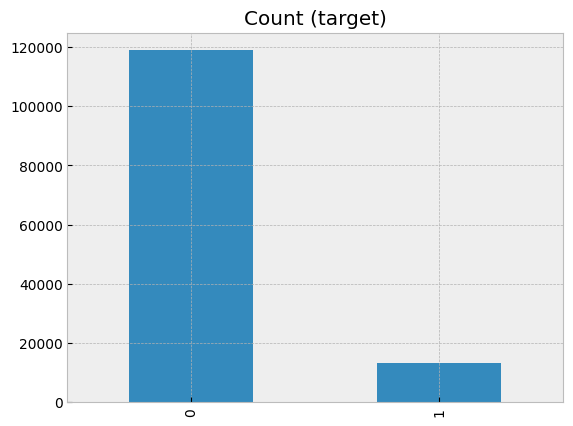

<Figure size 1000x800 with 0 Axes>

In [ ]:
# Address class imbalance of the target

df_dtc.target.value_counts().plot(kind='bar', title='Count (target)')

plt.style.use('bmh')
plt.figure(figsize=(10, 8))

plt.show()

Random over-sampling:
0    118901
1    118901
Name: target, dtype: int64


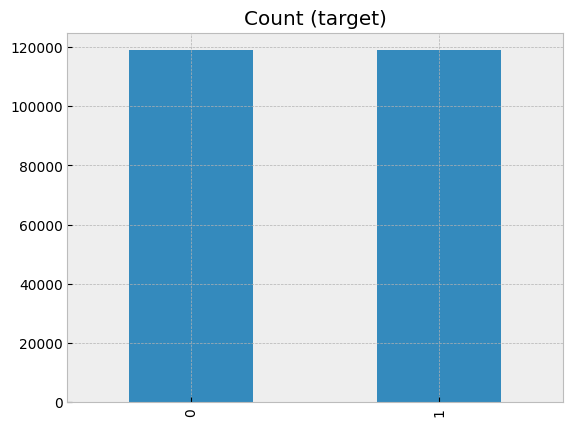

<Figure size 1000x800 with 0 Axes>

In [ ]:
# Oversample the minority class using "random over sampling"
# This linear approach supports cleaner interpetation of
# feature importance.

count_class_0, count_class_1 = df_dtc.target.value_counts()

# Divide by class
df_class_0 = df_dtc[df_dtc['target'] == 0] #majority class
df_class_1 = df_dtc[df_dtc['target'] == 1] #minority class

df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_over.target.value_counts())

df_over.target.value_counts().plot(kind='bar', title='Count (target)')

plt.style.use('bmh')
plt.figure(figsize=(10, 8))

plt.show()

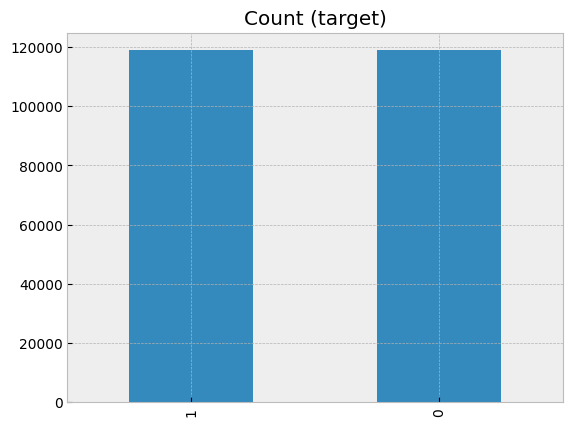

In [ ]:
# Shuffle the array before train/test split

df_over = shuffle(df_over,random_state=0)
df_over.target.value_counts().plot(kind='bar', title='Count (target)');

In [ ]:
# Train/test splits

X, y = df_over, df_over.pop("target")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
# Fit and score the model

model_dtc.fit(X_train, y_train.values)
score_train = model_dtc.score(X_train, y_train)
print("score_train: ", score_train)

score_train:  0.7477075448605698


In [ ]:
# Confusion matrix

y_pred = model_dtc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.78      0.69      0.73     39202
           1       0.72      0.81      0.76     39273

    accuracy                           0.75     78475
   macro avg       0.75      0.75      0.75     78475
weighted avg       0.75      0.75      0.75     78475



Results above are reasonable, but may be due to overfitting.

Selecting the appropriate value to plot train vs test to indenitfy potential ofverfitting.

**Accuracy**
<br>
<br>
Pros:
<br>
Simplicity: Accuracy is straightforward to understand and interpret. It's the percentage of correctly classified instances out of all instances.
Usefulness in Balanced Datasets: In cases where classes are balanced, accuracy can be a reliable measure of model performance.
<br>
<br>
Cons:
<br>
Misleading in Imbalanced Datasets: In situations where there is a significant class imbalance, accuracy can be misleading. A model could predict the majority class for all instances and still achieve high accuracy.
No Insight into Type I/II Errors: Accuracy doesn't distinguish between the types of errors (false positives and false negatives).
<br>
<br>
**F1-Score**
<br>
<br>
Pros:
<br>
Balance Between Precision and Recall: F1-score provides a balance between precision and recall. It is especially useful in cases where we need to balance false positives and false negatives.
Better for Imbalanced Datasets: It is more informative than accuracy in case of an imbalanced dataset.
<br>
<br>
Cons:
<br>
More Complex to Understand: F1-score is not as intuitive as accuracy, especially for non-technical stakeholders.
Not a Single Error Type Focus: If your specific problem requires optimizing specifically for either precision or recall (but not both), F1-score might not be the best metric.
<br>
<br>
**ROC-AUC**
<br>
<br>
Pros:
<br>
Performance Across Thresholds: AUC-ROC measures the model's performance across all classification thresholds, providing a comprehensive view of its effectiveness.
Useful for Imbalanced Datasets: Like F1-score, it is more informative than accuracy for imbalanced classes.
<br>
<br>
Cons:
<br>
Can Be Overly Optimistic: In highly imbalanced datasets, ROC-AUC might present an overly optimistic view of the model’s performance.
Complexity in Interpretation: Understanding and explaining ROC curves and AUC can be more complex compared to straightforward metrics like accuracy.

>1, train: 0.718, test: 0.718
>2, train: 0.735, test: 0.737
>3, train: 0.742, test: 0.744
>4, train: 0.745, test: 0.747
>5, train: 0.746, test: 0.747
>6, train: 0.747, test: 0.748
>7, train: 0.747, test: 0.748
>8, train: 0.747, test: 0.749
>9, train: 0.748, test: 0.749
>10, train: 0.748, test: 0.749
>11, train: 0.748, test: 0.749
>12, train: 0.748, test: 0.749
>13, train: 0.748, test: 0.749
>14, train: 0.748, test: 0.749


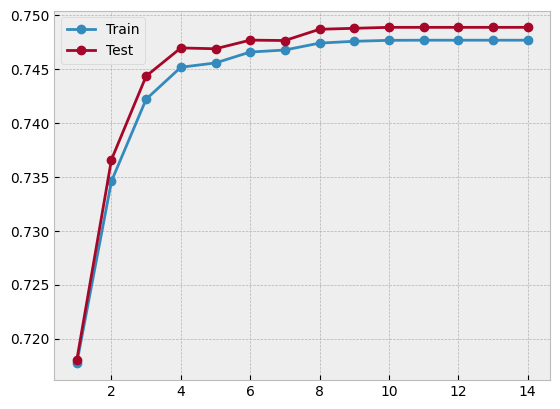

In [ ]:
# Look for overfitting via Accuracy

# Define the tree depths to evaluate
values = [i for i in range(1, 15)]

# Define lists to collect scores
train_scores, test_scores = list(), list()

# Evaluate for each depth
for i in values:

  # configure the model
  model_dtc = DecisionTreeClassifier(max_depth=i)

    # fit model on the training dataset
  model_dtc.fit(X_train, y_train)

  # evaluate on the train dataset
  train_yhat = model_dtc.predict(X_train)
  train_acc = accuracy_score(y_train, train_yhat)
  train_scores.append(train_acc)

  # evaluate on the test dataset
  test_yhat = model_dtc.predict(X_test)
  test_acc = accuracy_score(y_test, test_yhat)
  test_scores.append(test_acc)

# summarize progress
  print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()

In [ ]:
# Look for overfitting via F1-score

# Define the tree depths to evaluate
values = [i for i in range(1, 15)]

# Define lists to collect scores
train_scores, test_scores = list(), list()

# Evaluate for each depth
for i in values:
    # Configure the model
    model_dtc = DecisionTreeClassifier(max_depth=i)

    # Fit model on the training dataset
    model_dtc.fit(X_train, y_train)

    # Evaluate on the train dataset
    train_yhat = model_dtc.predict(X_train)
    train_f1 = f1_score(y_train, train_yhat, average='binary')  # Modify for binary/multiclass
    train_scores.append(train_f1)

    # Evaluate on the test dataset
    test_yhat = model_dtc.predict(X_test)
    test_f1 = f1_score(y_test, test_yhat, average='binary')  # Modify for binary/multiclass
    test_scores.append(test_f1)

    # Summarize progress
    print('>%d, train: %.3f, test: %.3f' % (i, train_f1, test_f1))

# Plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()


Lower splits show some strage behavior where the Test set is out  preforming the Tran set.

Bayesian-Optimization Library:

Pro: Offers a probabilistic model that can efficiently find the optimal parameters, especially useful when the number of experiments is limited.
Con: Might be less efficient in high-dimensional space and requires careful choice of the prior.
Scikit-Optimize:

Pro: Integrates seamlessly with scikit-learn and offers several methods including Bayesian optimization, which is useful for optimizing expensive-to-evaluate functions.
Con: Limited to optimization tasks and might not be as scalable as some other libraries.
GPyOpt:

Pro: Built on Gaussian Process models, it is excellent for fine-tuning where evaluations of the function are expensive.
Con: Can be slower and less practical for large-scale hyperparameter optimization due to the computational cost of Gaussian Processes.
Hyperopt:

Pro: Uses Bayesian optimization and supports parallelization, making it efficient for large searches.
Con: Can be complex to configure and understand, especially for beginners.
SHERPA:

Pro: Designed for hyperparameter tuning of machine learning models, supports a variety of algorithms, and is easy to use.
Con: Might not offer as wide a range of optimization algorithms compared to some other tools.
Optuna:

Pro: A modern library with an easy-to-use interface, it offers efficient and flexible optimization with visualization features.
Con: Its flexibility might come at the cost of a steeper learning curve for advanced features.
Ray Tune:

Pro: Highly scalable, supports a wide range of optimization algorithms, and integrates well with deep learning frameworks.
Con: Its broad functionality can make it more complex to set up and use.
Neural Network Intelligence (NNI):

Pro: Designed for neural networks, it offers a rich set of tuning strategies and easy integration with popular deep learning frameworks.
Con: More focused on neural networks, might be less applicable for other types of models.
MLMachine:

Pro: Provides an easy-to-use framework for machine learning workflows, including hyperparameter tuning.
Con: Less known and might lack some advanced features or optimizations found in more established libraries.
Talos:

Pro: Specifically designed for Keras models, making it very convenient for users of this framework.
Con: Limited to Keras, which might not be suitable if you're using different machine learning frameworks.
GridSearchCV:

Pro: Part of scikit-learn, very straightforward and easy to use for exhaustive search over specified parameter values.
Con: Computationally expensive as it evaluates all possible combinations and not efficient for large hyperparameter spaces.

In [ ]:
# Get model parameters

model = DecisionTreeClassifier()
for parameter in model.get_params():
    print(parameter)

ccp_alpha
class_weight
criterion
max_depth
max_features
max_leaf_nodes
min_impurity_decrease
min_samples_leaf
min_samples_split
min_weight_fraction_leaf
random_state
splitter


Gini Impurity
Pros:

Faster Computation: Gini impurity is computationally less intensive as it doesn't involve logarithmic calculations, which can be advantageous for large datasets.
Performance: It tends to work well in practice and is the default in many decision tree algorithms, like in scikit-learn's DecisionTreeClassifier.
Cons:

Less Sensitive to Changes in Class Probabilities: Gini impurity might be less sensitive to probability changes of the minority class, as it squares the probability terms.
Entropy (Information Gain)
Pros:

Sensitivity to Class Probability Changes: Entropy is more sensitive to changes in the class probabilities of the nodes, potentially leading to more balanced trees.
Information Theoretic Model: It has a basis in information theory, providing a clear interpretation in terms of information content and uncertainty.
Cons:

Computational Intensity: Calculating entropy involves logarithmic computations, which can be more computationally intensive than Gini impurity, especially for very large datasets.
Can Lead to Overfitting: In some cases, because entropy is more sensitive to class probabilities, it can lead to models that are more complex and potentially overfitted.

In [ ]:
# Set hyper-parameter dictionary to tune the model

param_dict = {'criterion' :['gini', 'entropy'],
            'max_depth' :range(1,15),
            'min_samples_split' : range(20, 50,10), # From Central Limit Theory
            'min_samples_leaf': range(20, 50, 10),
             'ccp_alpha' :[0.0001, 0.001, 0.01]}

tree_class = DecisionTreeClassifier()

grid = GridSearchCV(estimator=tree_class,
        param_grid = param_dict,
        cv = 5,
        verbose= 1,
        n_jobs = -1)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 756 candidates, totalling 3780 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0001, 0.001, 0.01],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 15),
                         'min_samples_leaf': range(20, 50, 10),
                         'min_samples_split': range(20, 50, 10)},
             verbose=1)

In [ ]:
# Extact the best preforming tested parameter values

grid.best_params_

{'ccp_alpha': 0.0001,
 'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_leaf': 20,
 'min_samples_split': 20}

In [ ]:
# Update model

model_dtc_p=DecisionTreeClassifier(ccp_alpha = 0.0001,
                                   criterion ='entropy',
                                   max_depth = 6,
                                   min_samples_split = 20,
                                   min_samples_leaf = 20)


In [ ]:
#Fit and re-score the model

model_dtc_p.fit(X_train, y_train.values.ravel())
score_train = model_dtc_p.score(X_test, y_test)
print("score_train: ", score_train)

score_train:  0.7473590315387066


In [ ]:
# Confusion matrix

y_pred = model_dtc_p.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.77      0.70      0.73     39202
           1       0.73      0.80      0.76     39273

    accuracy                           0.75     78475
   macro avg       0.75      0.75      0.75     78475
weighted avg       0.75      0.75      0.75     78475



>1, train: 0.718, test: 0.718
>2, train: 0.735, test: 0.737
>3, train: 0.742, test: 0.744
>4, train: 0.745, test: 0.747
>5, train: 0.746, test: 0.747
>6, train: 0.747, test: 0.748
>7, train: 0.747, test: 0.748
>8, train: 0.747, test: 0.749
>9, train: 0.748, test: 0.749
>10, train: 0.748, test: 0.749
>11, train: 0.748, test: 0.749
>12, train: 0.748, test: 0.749
>13, train: 0.748, test: 0.749
>14, train: 0.748, test: 0.749


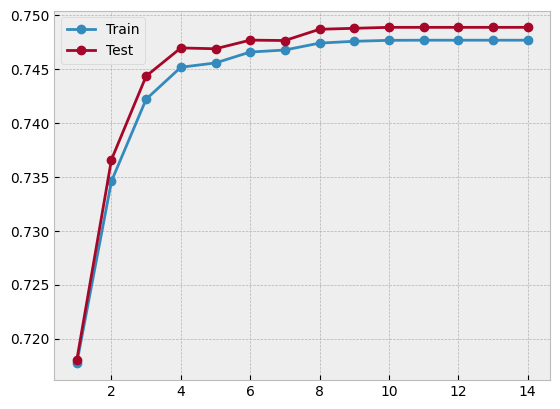

In [ ]:
# Look again for overfitting via Accuracy


# Define the tree depths to evaluate
values = [i for i in range(1, 15)]

# Define lists to collect scores
train_scores, test_scores = list(), list()

# Evaluate for each depth
for i in values:

  # configure the model
  model_dtc_p = DecisionTreeClassifier(max_depth=i)

    # fit model on the training dataset
  model_dtc_p.fit(X_train, y_train)

  # evaluate on the train dataset
  train_yhat = model_dtc_p.predict(X_train)
  train_acc = accuracy_score(y_train, train_yhat)
  train_scores.append(train_acc)

  # evaluate on the test dataset
  test_yhat = model_dtc_p.predict(X_test)
  test_acc = accuracy_score(y_test, test_yhat)
  test_scores.append(test_acc)

# summarize progress
  print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()

Both the accuracey and F-1 based curves show an issue in the lower branches.

Churn: ROC AUC=0.500
Logistic: ROC AUC=0.827


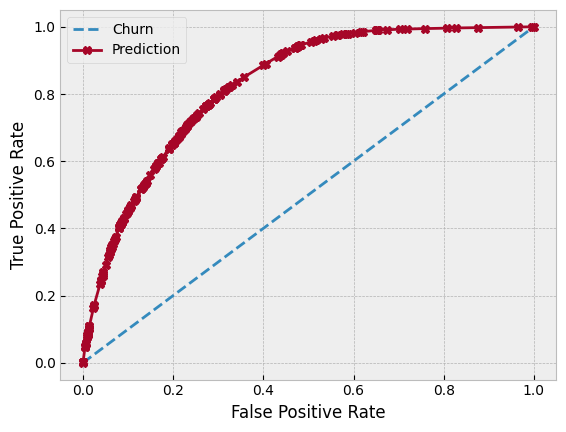

In [ ]:
# ROC curve and AUC

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = model_dtc_p.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('Churn: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Churn')
plt.plot(lr_fpr, lr_tpr, marker='X', label='Prediction')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

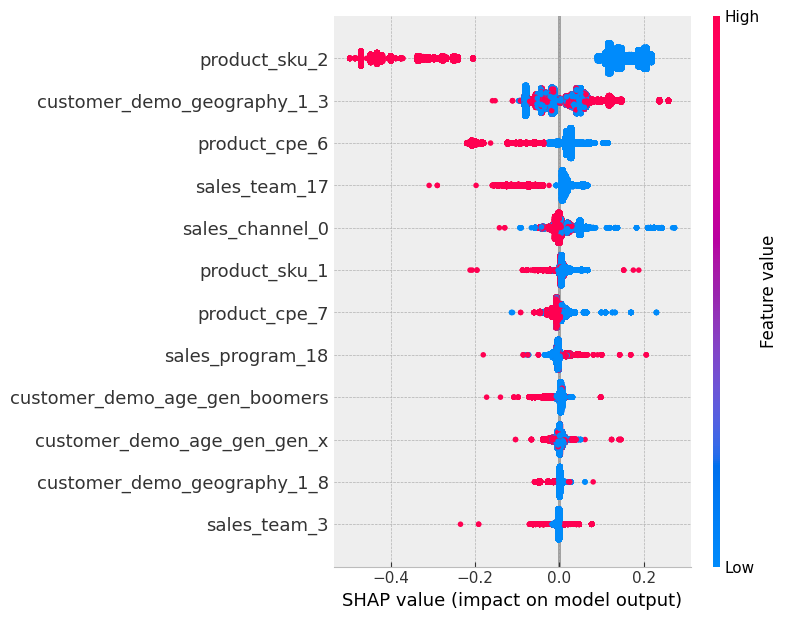

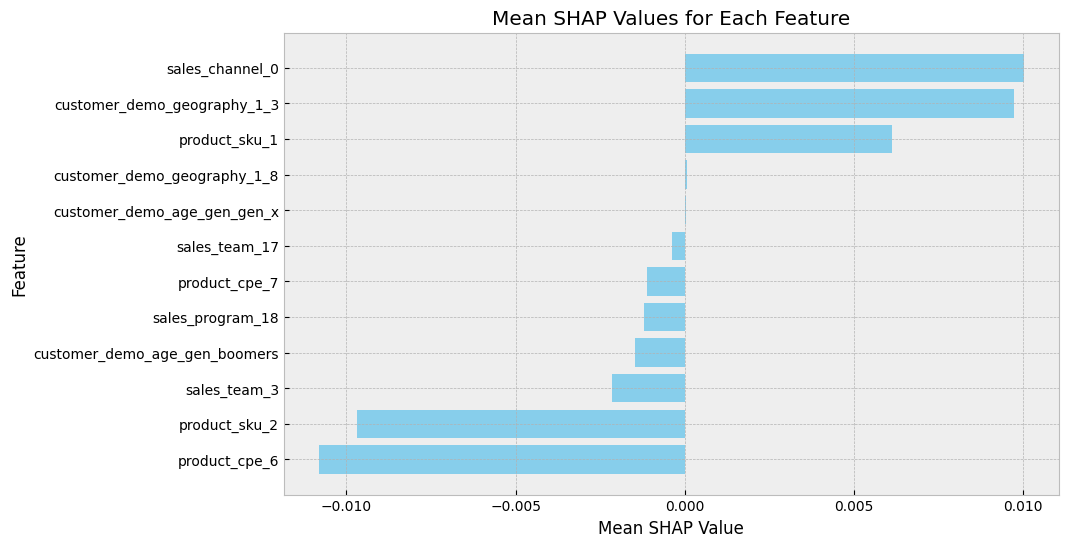

                          Feature  Min SHAP Value  Mean SHAP Value  \
5                   product_cpe_6       -0.219110        -0.010805   
1                   product_sku_2       -0.496807        -0.009691   
3                    sales_team_3       -0.234400        -0.002164   
8   customer_demo_age_gen_boomers       -0.172464        -0.001472   
7                sales_program_18       -0.180415        -0.001203   
6                   product_cpe_7       -0.113368        -0.001103   
4                   sales_team_17       -0.308775        -0.000383   
9     customer_demo_age_gen_gen_x       -0.103882         0.000026   
11    customer_demo_geography_1_8       -0.058745         0.000052   
0                   product_sku_1       -0.211723         0.006115   
10    customer_demo_geography_1_3       -0.158641         0.009725   
2                 sales_channel_0       -0.142148         0.010015   

    Max SHAP Value  
5         0.114620  
1         0.218516  
3         0.076569  
8    

In [ ]:
# Print Global SHAP values

exp = TreeExplainer(model_dtc)
sv = exp.shap_values(X_test)

# Initialize an empty list to store feature statistics
feature_stats = []
feature_to_drop = []

# Loop through each feature and calculate min, mean, and max SHAP values
for i in range(len(X_test.columns)):
    feature_name = X_test.columns[i]
    shap_values_feature = sv[1][:, i]
    min_val = np.min(shap_values_feature)
    mean_val = np.mean(shap_values_feature)
    max_val = np.max(shap_values_feature)
    feature_stats.append([feature_name, min_val, mean_val, max_val]) # capture which features were dropped


    # Append the statistics to the list of features to drop
    # if 1==1:#not (min_val == mean_val == max_val == 0):
    if (min_val == mean_val == max_val == 0):
        feature_to_drop.append([feature_name, min_val, mean_val, max_val]) # capture which features were dropped

# Create a DataFrames of all feature with their min, mean, max values
feature_stats_df = pd.DataFrame(feature_stats, columns=['Feature', 'Min SHAP Value', 'Mean SHAP Value', 'Max SHAP Value'])

# Load CSV file to the specified path
csv_path = '/content/drive/MyDrive/Colab Notebooks/sklearn/feature_stats.csv'

# Save the DataFrame to the specified path as a CSV file
feature_stats_df.to_csv(csv_path, index=False)  # Set index=False to avoid saving the index column


# Create a DataFrames of dropped features
feature_to_drop_df = pd.DataFrame(feature_to_drop, columns=['Feature', 'Min SHAP Value', 'Mean SHAP Value', 'Max SHAP Value'])

# Load CSV file to the specified path
csv_path = '/content/drive/MyDrive/Colab Notebooks/sklearn/feature_to_drop_df.csv'

# Save the DataFrame to the specified path as a CSV file
feature_to_drop_df.to_csv(csv_path, index=False)  # Set index=False to avoid saving the index column


# Plots
# Display the SHAP summary plot for all features
shap.summary_plot(sv[1], X_test, max_display=20)

# Plotting the mean SHAP values for each feature
plt.figure(figsize=(10, len(feature_stats_df) / 2))  # Adjust the figure size as needed
feature_stats_df.sort_values(by='Mean SHAP Value', ascending=True, inplace=True)
plt.barh(feature_stats_df['Feature'], feature_stats_df['Mean SHAP Value'], color='skyblue')
plt.xlabel('Mean SHAP Value')
plt.ylabel('Feature')
plt.title('Mean SHAP Values for Each Feature')
plt.show()

print(feature_stats_df)


<Figure size 4000x1000 with 0 Axes>

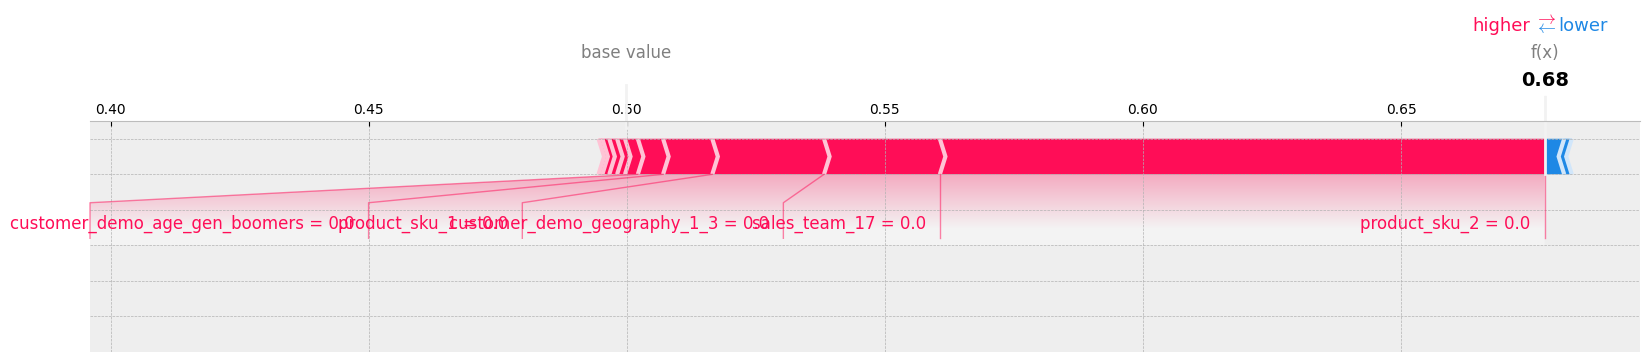

In [ ]:
# Force Plot visualization: single customer (Local SHAP values)

# Calculate SHAP values for the first row of the X_test dataset
shap_values_single = exp.shap_values(X_test.iloc[120]) # Good Exxample of really bad churn

# Initialize JavaScript visualization in Google Colab (even if it might not display)
shap.initjs()

# Generate a force plot using matplotlib backend
plt.figure(figsize=(40, 10))  # You can adjust the size as needed
shap.force_plot(exp.expected_value[1], shap_values_single[1], X_test.iloc[0], feature_names=X_test.columns, matplotlib=True)
plt.show()


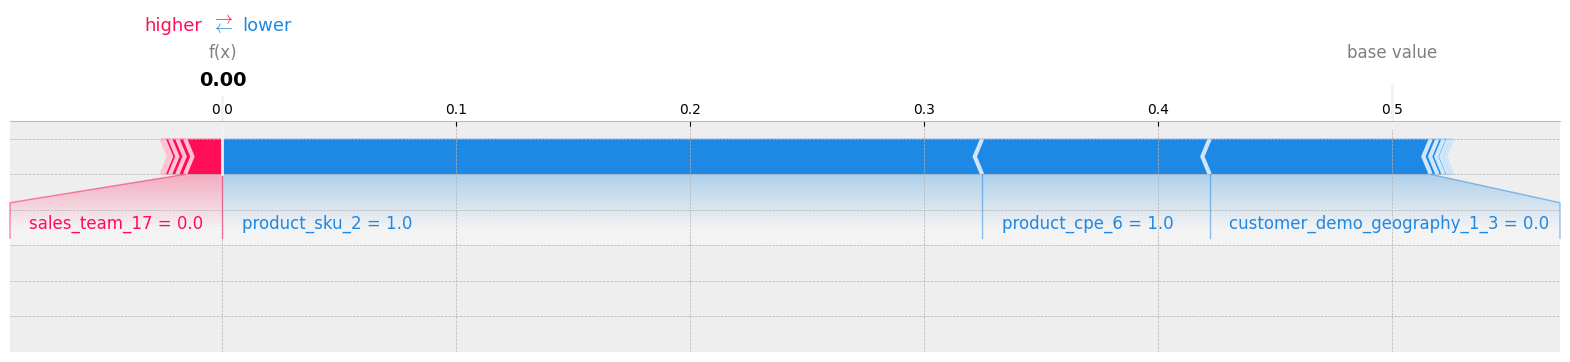

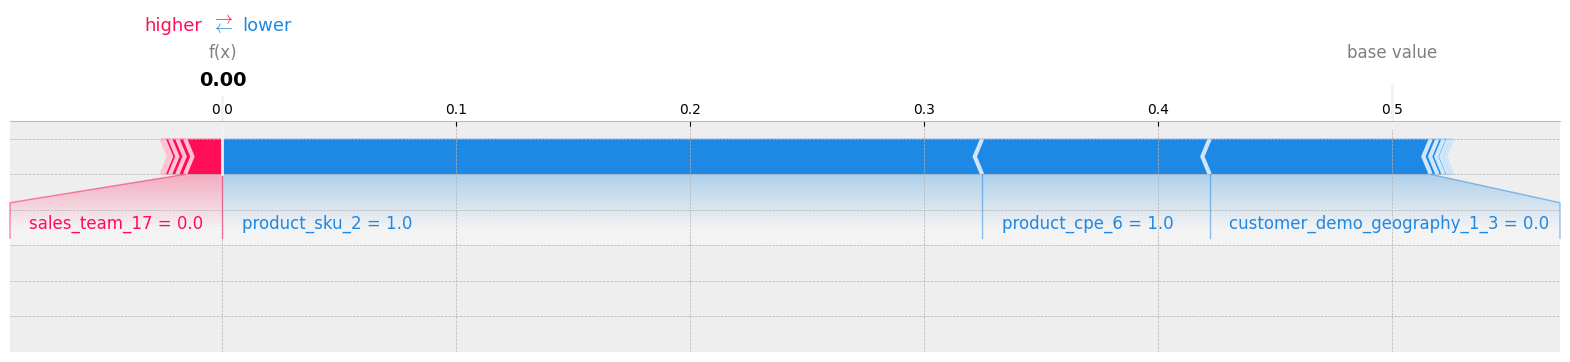

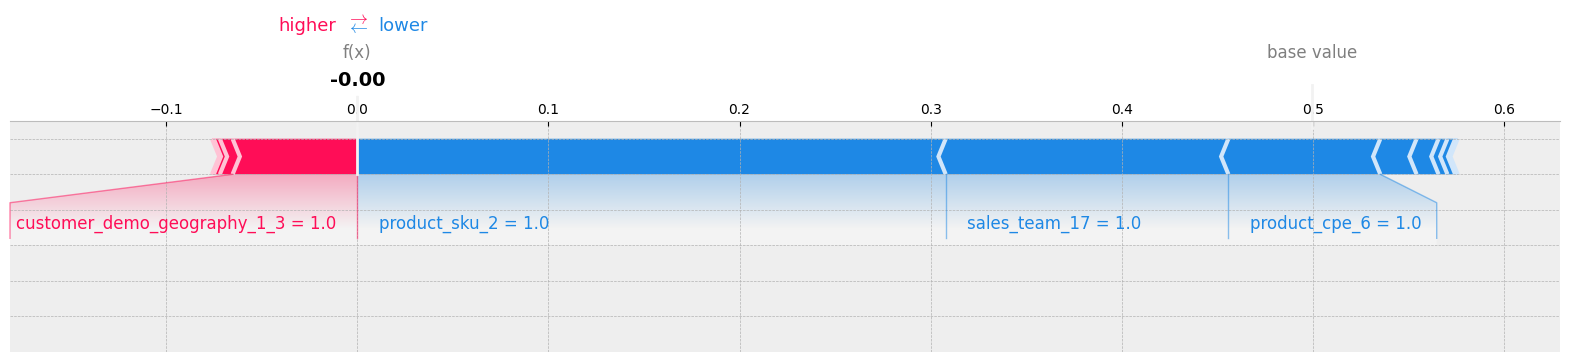

In [ ]:
# Filter customers based on all specified features and values simultaneously

high_value_features = {
    "product_cpe_6": 1,
    "product_sku_2": 1
    #"sales_team_3": 1
    #"customer_demo_age_gen_boomers" : 1
    #"sales_program_18" : 1
                       }

filtered_customers = X_test.copy()

for feature, value in high_value_features.items():
    filtered_customers = filtered_customers[filtered_customers[feature] == value]

# DataFrame to store SHAP values
shap_values_df = pd.DataFrame()

# Iterate over filtered customers to calculate SHAP values and generate force plots
for index, row in filtered_customers.iterrows():
    # Calculate SHAP values for the current example
    shap_values_example = exp.shap_values(row)

    # Append the SHAP values to the DataFrame
    shap_row_df = pd.DataFrame([shap_values_example[1]], columns=[f'shap_{col}' for col in X_test.columns])
    shap_values_df = pd.concat([shap_values_df, shap_row_df], ignore_index=True)

    # Generate a force plot for the example
    shap.initjs()
    shap.force_plot(exp.expected_value[1], shap_values_example[1], row, matplotlib=True)
    plt.show()

# Concatenate the SHAP values DataFrame with the filtered customers DataFrame
final_df = pd.concat([filtered_customers.reset_index(drop=True), shap_values_df], axis=1)

# Export to CSV
final_df.to_csv('shap_values.csv', index=False)

## Gradient Boost


In [ ]:
# For Random Forest Classifier
from sklearn.ensemble import GradientBoostingClassifier

df_gb = df_pre.copy()

In [ ]:
# Address class imbalance of the target

df_gb.target.value_counts().plot(kind='bar', title='Count (target)')

plt.style.use('bmh')
plt.figure(figsize=(10, 8))

plt.show()

In [ ]:
# Oversample the minority class using "random over sampling"
# This linear approach supports cleaner interpetation of
# feature importance with SHAP.

count_class_0, count_class_1 = df_dtc.target.value_counts()

# Divide by class
df_class_0 = df_gb[df_gb['target'] == 0] #majority class
df_class_1 = df_gb[df_gb['target'] == 1] #minority class

df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_over.target.value_counts())

df_over.target.value_counts().plot(kind='bar', title='Count (target)')

plt.style.use('bmh')
plt.figure(figsize=(10, 8))

plt.show()

In [ ]:
# Shuffle the array before train/test split

from sklearn.utils import shuffle

df_over = shuffle(df_over,random_state=0)
df_over.target.value_counts().plot(kind='bar', title='Count (target)');

In [ ]:
# Train/test splits

from sklearn.model_selection import train_test_split

X, y = df_over, df_over.pop("target")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) # Small test size only to support feature reduction via SHAP

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Initialize the Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

# Fit the model to the training data
gb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gb_model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


In [ ]:
# Confusion matrix

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score

y_pred = gb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

In [ ]:
# Look for any overfitting of the GB model

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Define the tree depths to evaluate
values = [i for i in range(1, 10)]

# Define lists to collect scores
train_scores, test_scores = list(), list()

# Evaluate for each depth
for i in values:
    # Initialize the Gradient Boosting Classifier with varying max_depth
    gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=i, random_state=0)

    # Fit the model to the training data
    gb_model.fit(X_train, y_train)

    # Evaluate on the train dataset
    train_yhat = gb_model.predict(X_train)
    train_acc = accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)

    # Evaluate on the test dataset
    test_yhat = gb_model.predict(X_test)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)

    # Summarize progress
    print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

# Plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.show()


In [ ]:
# Get model parameters

model = GradientBoostingClassifier()
for parameter in model.get_params():
    print(parameter)



In [ ]:
# Set hyper-parameter dictionary to tune the model
# and resolve any overfitting

from sklearn.model_selection import GridSearchCV

param_dict = {"criterion" :["friedman_mse", "squared_error"],
            "max_depth" :range(1,10),
            #"min_samples_split" :range(2,10),
            #"min_samples_leaf" :range(1,5),
             "ccp_alpha" :[0.0001, 0.001, 0.01]}

tree_class = GradientBoostingClassifier()

grid = GridSearchCV(estimator=tree_class,
        param_grid = param_dict,
        cv = 10,
        verbose= 1,
        n_jobs = 1)

grid.fit(X_train, y_train)

In [ ]:
# Extact the best preforming tested parameter values

grid.best_params_

In [ ]:
# Update model

model_dtc_p=DecisionTreeClassifier(ccp_alpha = 0.0001,
                                   criterion ='entropy',
                                   max_depth = 9)

In [ ]:
#Fit and re-score the model

model_dtc_p.fit(X_train, y_train.values.ravel())
score_train = model_dtc_p.score(X_test, y_test)
print("score_train: ", score_train)

In [ ]:
# Confusion matrix

from sklearn.metrics import classification_report, confusion_matrix

y_pred = model_dtc_p.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

In [ ]:
# ROC curve and AUC
model_gb = GradientBoostingClassifier()

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# fit a model
#model = DecisionTreeClassifier()
model_gb.fit(X_train, y_train.values)

# predict probabilities
lr_probs = model_dtc_p.predict_proba(X_test)


# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('Churn: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Churn')
plt.plot(lr_fpr, lr_tpr, marker='X', label='Prediction')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

In [ ]:
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import Image

# Train a decision tree model
model = DecisionTreeClassifier(max_depth=3)  # Limit depth for visualization
model.fit(X_train, y_train)

# Export as dot file
dot_data = export_graphviz(model, out_file=None,
                           feature_names=X_train.columns,
                           class_names=['0', '1'],  # Assuming binary classification with classes '0' and '1'
                           filled=True, rounded=True,
                           special_characters=True,
                           proportion=False,  # Set to 'True' to show percentages instead of sample counts
                           precision=2,  # Set precision for floating point numbers
                           label='all',  # Use 'root' to show labels at the root node or 'all' to show at all nodes
                           leaves_parallel=False)  # Set to 'True' to align leaf nodes horizontally

# Create graph from dot data
graph = graphviz.Source(dot_data)

# Render and show the graph
Image(graph.pipe(format='png'))


In [ ]:
# Feature Importance from the Gradient model

feature_importances = model_gb.feature_importances_

# To display feature importance
for i, feature in enumerate(X_train.columns):
    print(f'Feature: {feature}, Importance: {feature_importances[i]}')

## What follows is another full run but w/o over sample the minority class

*Results were not usable*

### Prepare data set for DTC algorithm

In [ ]:
# Parking the df at this point to allow for additional experiments

# For decision tree
df_dtc_2 = df_pre.copy()


In [ ]:
# Address class imbalance of the target

df_dtc_2.target.value_counts().plot(kind='bar', title='Count (target)')

plt.style.use('bmh')
plt.figure(figsize=(10, 8))

plt.show()

In [ ]:
# Shuffle the array before train/test split

from sklearn.utils import shuffle

df_dtc_2 = shuffle(df_dtc_2,random_state=0)
df_dtc_2.target.value_counts().plot(kind='bar', title='Count (target)');

In [ ]:
# Train/test splits

from sklearn.model_selection import train_test_split

X, y = df_dtc_2, df_dtc_2.pop("target")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) # Small test size only to support feature reduction via SHAP

In [ ]:
#Create Decision Tree classifer object

from sklearn.tree import DecisionTreeClassifier

model_dtc_2 = DecisionTreeClassifier()

In [ ]:
# Fit and score the model

model_dtc_2.fit(X_train, y_train.values.ravel())
score_train = model_dtc_2.score(X_train, y_train)
print("score_train: ", score_train)
print(X_train.shape, y_train.shape)

In [ ]:
# Confusion matrix

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score

y_pred = model_dtc_2.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

In [ ]:
# Look for any overfitting of the DTC model

from sklearn.metrics import accuracy_score

# Define the tree depths to evaluate
values = [i for i in range(1, 15)]

# Define lists to collect scores
train_scores, test_scores = list(), list()

# Evaluate for each depth
for i in values:

  # configure the model
  model_dtc = DecisionTreeClassifier(max_depth=i)

    # fit model on the training dataset
  model_dtc_2.fit(X_train, y_train)

  # evaluate on the train dataset
  train_yhat = model_dtc_2.predict(X_train)
  train_acc = accuracy_score(y_train, train_yhat)
  train_scores.append(train_acc)

  # evaluate on the test dataset
  test_yhat = model_dtc_2.predict(X_test)
  test_acc = accuracy_score(y_test, test_yhat)
  test_scores.append(test_acc)

# summarize progress
  print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()

In [ ]:
# Get model parameters

model = DecisionTreeClassifier()
for parameter in model.get_params():
    print(parameter)

In [ ]:
# Set hyper-parameter dictionary to tune the model
# and resolve any overfitting

from sklearn.model_selection import GridSearchCV

param_dict = {"criterion" :["gini", "entropy"],
            "max_depth" :range(1,10),
            #"min_samples_split" :range(2,10),
            #"min_samples_leaf" :range(1,5),
             "ccp_alpha" :[0.0001, 0.001, 0.01]}

tree_class = DecisionTreeClassifier()

grid = GridSearchCV(estimator=tree_class,
        param_grid = param_dict,
        cv = 10,
        verbose= 1,
        n_jobs = 1)

grid.fit(X_train, y_train)

In [ ]:
# Extact the best preforming tested parameter values

grid.best_params_

In [ ]:
# Update model

model_dtc_p=DecisionTreeClassifier(ccp_alpha = 0.0001,
                                   criterion ='entropy',
                                   max_depth = 6)

In [ ]:
#Fit and re-score the model

model_dtc_p.fit(X_train, y_train.values.ravel())
score_train = model_dtc_p.score(X_test, y_test)
print("score_train: ", score_train)

In [ ]:
# Confusion matrix

from sklearn.metrics import classification_report, confusion_matrix

y_pred = model_dtc_p.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

In [ ]:
# ROC curve and AUC

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# fit a model
#model = DecisionTreeClassifier()
#model_dtc_p.fit(X_train, y_train.values.ravel())

# predict probabilities
lr_probs = model_dtc_p.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('Churn: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Churn')
plt.plot(lr_fpr, lr_tpr, marker='X', label='Prediction')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

In [ ]:
# Prepare enviornment for feature importance/reduction
# https://towardsdatascience.com/demystify-your-ml-model-with-shap-fc191a1cb08a

!pip install shap

In [ ]:
import matplotlib.pyplot as plt
import shap as shap
from shap import TreeExplainer, summary_plot

exp = TreeExplainer(model_dtc)
sv = exp.shap_values(X_test)

# Initialize an empty list to store feature statistics
feature_stats = []
feature_to_drop = []

# Loop through each feature and calculate min, mean, and max SHAP values
for i in range(len(X_test.columns)):
    feature_name = X_test.columns[i]
    shap_values_feature = sv[1][:, i]
    min_val = np.min(shap_values_feature)
    mean_val = np.mean(shap_values_feature)
    max_val = np.max(shap_values_feature)
    feature_stats.append([feature_name, min_val, mean_val, max_val]) # capture which features were dropped


    # Append the statistics to the list of features to drop
    # if 1==1:#not (min_val == mean_val == max_val == 0):
    if (min_val == mean_val == max_val == 0):
        feature_to_drop.append([feature_name, min_val, mean_val, max_val]) # capture which features were dropped

# Create a DataFrames of all feature with their min, mean, max values
feature_stats_df = pd.DataFrame(feature_stats, columns=['Feature', 'Min SHAP Value', 'Mean SHAP Value', 'Max SHAP Value'])

# Load CSV file to the specified path
csv_path = '/content/drive/MyDrive/Colab Notebooks/sklearn/feature_stats.csv'

# Save the DataFrame to the specified path as a CSV file
feature_stats_df.to_csv(csv_path, index=False)  # Set index=False to avoid saving the index column


# Create a DataFrames of dropped features
feature_to_drop_df = pd.DataFrame(feature_to_drop, columns=['Feature', 'Min SHAP Value', 'Mean SHAP Value', 'Max SHAP Value'])

# Load CSV file to the specified path
csv_path = '/content/drive/MyDrive/Colab Notebooks/sklearn/feature_to_drop_df.csv'

# Save the DataFrame to the specified path as a CSV file
feature_to_drop_df.to_csv(csv_path, index=False)  # Set index=False to avoid saving the index column


# Plots
# Display the SHAP summary plot for all features
shap.summary_plot(sv[1], X_test, max_display=20)

# Plotting the mean SHAP values for each feature
plt.figure(figsize=(10, len(feature_stats_df) / 2))  # Adjust the figure size as needed
feature_stats_df.sort_values(by='Mean SHAP Value', ascending=True, inplace=True)
plt.barh(feature_stats_df['Feature'], feature_stats_df['Mean SHAP Value'], color='skyblue')
plt.xlabel('Mean SHAP Value')
plt.ylabel('Feature')
plt.title('Mean SHAP Values for Each Feature')
plt.show()

print(feature_stats_df)


In [ ]:
# Force Plot visualization: single customer (Local SHAP values)


# Calculate SHAP values for the first row of the X_test dataset
shap_values_single = exp.shap_values(X_test.iloc[101])

# Initialize JavaScript visualization in Google Colab (even if it might not display)
shap.initjs()

# Generate a force plot using matplotlib backend
plt.figure(figsize=(40, 10))  # You can adjust the size as needed
shap.force_plot(exp.expected_value[1], shap_values_single[1], X_test.iloc[0], feature_names=X_test.columns, matplotlib=True)
plt.show()


In [ ]:
# Manually specify the top features and their values for filtering
high_value_features = {"product_sku_2": 1,
                        "product_cpe_6": 1,
                        "sales_team_17": 1,
                        "sales_program_13": 1
                       }
# Create a DataFrame to store filtered customers
filtered_customers = pd.DataFrame()

# Iterate over specified features and values
for feature, value in high_value_features.items():
    # Filter customers based on the specified feature and value
    filtered_customers = pd.concat([filtered_customers, X_test[X_test[feature] == value]])

# Now, filtered_customers contains only the customers that match the specified features and values

# Iterate over filtered customers to calculate and print force plots
for index, row in filtered_customers.iterrows():
    # Calculate SHAP values for the current example
    shap_values_example = exp.shap_values(row)

    # Generate a force plot for the example
    shap.initjs()  # Initialize JS visualization (if not already done)
    shap.force_plot(exp.expected_value[1], shap_values_example[1], row, matplotlib=True)
    plt.show()


## Appendix / Parking lot

In [ ]:
import shap
from shap import TreeExplainer


# Create the SHAP explainer and calculate SHAP values
exp = TreeExplainer(model_dtc)
sv = exp.shap_values(X_test)

# Initialize an empty list for features to drop
feature_to_drop = []

# Loop through each feature and calculate min, mean, and max SHAP values
for i in range(len(X_test.columns)):
    feature_name = X_test.columns[i]
    shap_values_feature = sv[1][:, i]
    # min_val = np.min(shap_values_feature)
    # max_val = np.max(shap_values_feature)
    mean_val = np.mean(shap_values_feature)


    # Append the feature to the list
    #if (min_val == mean_val == max_val == 0):
    if (mean_val == 0):
        feature_to_drop.append(feature_name)

# Print the list of features to drop
print("Features to drop based on SHAP values:", feature_to_drop)



In [ ]:

# Your pandas operation that causes the warning


#from sklearn.datasets import make_classification

#import xgboost as xgb

#from sklearn import metrics
#from sklearn.preprocessing import LabelEncoder, StandardScaler
#from sklearn.feature_selection import chi2, RFE

#from sklearn.tree import export_graphviz
#from sklearn.neighbors import KNeighborsClassifier

#from sklearn.metrics import mean_squared_error

#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import RepeatedStratifiedKFold
#from sklearn.feature_selection import RFE
#from sklearn.pipeline import Pipeline
#from sagemaker import get_execution_role
#from sklearn.externals.six import StringIO
#from sklearn.tree import export_graphviz
#from sklearn.model_selection import validation_curve

#from sklearn.metrics import accuracy_score
#from sklearn.neighbors import KNeighborsClassifier

#from sklearn import metrics
#from sklearn import tree
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.manifold import TSNE

#from sklearn.svm import LinearSVC, SVC
#from sklearn.linear_model import LogisticRegression, SGDClassifier
#!pip install flake8 pycodestyle_magic

# Needed for Sagemaker
#!pip install botocore

# Needed for Sagemaker
#pip install s3fs==2021.08.0

#from numpy import mean
#from numpy import std

In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

# Assuming sv contains the SHAP values computed earlier
# and X_test is your test dataset

# Initialize an empty list to store feature statistics
feature_stats = []

# Loop through each feature and calculate min, mean, and max SHAP values
for i in range(len(X_test.columns)):
    feature_name = X_test.columns[i]
    shap_values_feature = sv[1][:, i]
    min_val = np.min(shap_values_feature)
    mean_val = np.mean(shap_values_feature)
    max_val = np.max(shap_values_feature)

    # Append the statistics to the list if they are not all zero
    if not (min_val == mean_val == max_val == 0):
        feature_stats.append([feature_name, min_val, mean_val, max_val])

# Create a DataFrame from the list
feature_stats_df = pd.DataFrame(feature_stats, columns=['Feature', 'Min SHAP Value', 'Mean SHAP Value', 'Max SHAP Value'])

# Display the DataFrame
print(feature_stats_df)

# Display the SHAP summary plot for all features
shap.summary_plot(sv[1], X_test, max_display=100)


In [ ]:
import matplotlib.pyplot as plt
import shap

# Assuming exp is your pre-initialized SHAP explainer and other necessary imports are done
custom_baseline = 0.50  # Your custom baseline value

# Iterate over filtered customers to calculate and print force plots
for index, row in filtered_customers.iterrows():
    # Calculate SHAP values for the current example
    shap_values_example = exp.shap_values(row)

    # Manually adjust the expected value for the force plot
    adjusted_expected_value = custom_baseline

    # Generate a force plot for the example with the adjusted expected value
    shap.initjs()  # Initialize JS visualization (if not already done)
    shap.force_plot(adjusted_expected_value, shap_values_example[1], row, matplotlib=True)
    plt.show()


In [ ]:
# Feature importance matrix

from shap import TreeExplainer, summary_plot

model_dtc_p = model_dtc_p.fit(X_train, y_train)

exp = TreeExplainer(model_dtc_p)
sv = exp.shap_values(X_test)

# Get the feature names
feature_names = X_test.columns

# Get the feature importance values for the chosen row
feature_importance_values = sv[1][0]

# Ensure that the lengths match
if len(feature_names) == len(feature_importance_values):
    # Create a DataFrame with feature names and their importance values
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance_values})

    # Print the DataFrame
    #print("Feature Importance DataFrame:")
    #print(feature_importance_df)


# Sort the DataFrame by the importance column in ascending order
sorted_df = feature_importance_df.sort_values(by='Importance')

# Iterate over the sorted DataFrame and print feature and importance
for Feature, Importance in sorted_df.itertuples(index=False):
    print(f'Feature: {Feature}, Importance: {Importance}')

In [ ]:
# What is the models base value ?

# Assuming model_dtc_p is your decision tree classifier and is already fitted with X_train and y_train
# model_dtc_p = model_dtc_p.fit(X_train, y_train)

# Initialize the TreeExplainer with your fitted model
exp = TreeExplainer(model_dtc_p)

# Print the expected values
print("Expected Value for Class 0:", exp.expected_value[0])
print("Expected Value for Class 1:", exp.expected_value[1])

In [ ]:
# Feature importance visualization: Global SHAP values

import shap as shap
from shap import TreeExplainer, summary_plot

model_dtc_p = model_dtc_p.fit(X_train, y_train)

exp = TreeExplainer(model_dtc_p)
sv = exp.shap_values(X_test)
summary_plot(sv[1], X_test, max_display=20)

In [ ]:
# Split into training and testing dataset.

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df,train_size=0.66)
display(train_data)
display(test_data)

In [ ]:
# Split the target from the feature for the training data

X_train = train_data.iloc[:,1:]
X_train.head()

In [ ]:
# Split the target from the feature for the training data

y_train = train_data.iloc[:, [0]]
y_train.head()

In [ ]:
# Split the target from the feature for the test data

X_test = test_data.iloc[:,1:]
X_test.head()

In [ ]:
# Split the target from the feature for the test data

y_test = test_data.iloc[:, [0]]
y_test.head()

In [ ]:
import pandas as pd

heart_df = df_over.copy()

X, y = heart_df, heart_df.pop("target")

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
# Collinearity: PCA

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_independent)  # X_independent contains your numeric features

X_scaled = df.select_dtypes(include=['int64', 'float64'])


# Apply PCA with the desired number of components
pca = PCA(n_components=2)  # Adjust the number of components as needed
X_pca = pca.fit_transform(X_scaled)

# X_pca contains the transformed features
print("Explained Variance Ratio:")
print(pca.explained_variance_ratio_)

In [ ]:
# evaluate RFE for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# create pipeline
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

In [ ]:
# Train/test splits

X, y = df, df.pop("target")

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model = XGBClassifier()
model.fit(X_train, y_train)

In [ ]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

shap.plots.bar(shap_values)

In [ ]:
import shap

# Assuming you have already computed shap_values and the expected value
# Replace 'expected_value' with the actual expected value for your model
expected_value = 0.0  # Replace with your model's expected value

# Plot the SHAP values for a specific data point (e.g., index 100)
shap.plots.force(expected_value, shap_values[100])


In [ ]:
# Bin/classify of fulfillment_time

df['fulfillment'] = df['fulfillment_time'].apply(lambda fulfillment_time:
    1 if fulfillment_time == 1 else 0
)

# Drop fulfillment_time
df.drop('fulfillment_time', axis=1, inplace=True)

### Original model. I dont have the source file.

In [ ]:
df_raw = pd.read_csv(r'/content/qp_model_202301062016.csv')
print(df_raw)

In [ ]:
df_raw.head()

In [ ]:

df_raw.info()

#<class 'pandas.core.frame.DataFrame'>
##RangeIndex: 265913 entries, 0 to 265912
#d ata columns (total 17 columns):
# Column                           Non-Null Count   Dtype
-#--  ------                           --------------   -----
# 0   churn_flag                       265913 non-null  int64
# 1   age                              265913 non-null  int64
# 2   data_points                      265913 non-null  int64
# 3   voice_points                     265913 non-null  int64
# 4   sms_points                       265913 non-null  int64
# 5   total_points                     265913 non-null  int64
# 6   count_of_approved_accounts_hist  265913 non-null  int64
# 7   master                           265913 non-null  object
# 8   state                            265913 non-null  object
# 9   channel                          265913 non-null  object
# 10  plantype                         265913 non-null  object
# 11  eligibilityprogram               265913 non-null  object
# 12  devicebrand                      265913 non-null  object
# 13  bqplancode                       265913 non-null  int64
# 14  is_ported                        265913 non-null  int64
# 15  eligibility_new                  265913 non-null  int64
# 16  groupchannelinperson             265913 non-null  int64

In [ ]:
# Original model. I dont have the source file.
df_raw.describe()

In [ ]:
# Original model. I dont have the source file.
df_raw.hist(bins=50, figsize=(20,15))
plt.show()

Need to address class imbalance.<br>
groupchannelinperson is almost certainly wrong.

In [ ]:

# Look for Null values
df_raw.isnull().sum()

In [ ]:

nan_count = df_raw.isna().sum()
print(nan_count )

In [ ]:

df_raw = df_raw.drop (['total_points','count_of_approved_accounts_hist','master','state','channel',
                       'eligibilityprogram','devicebrand','bqplancode','is_ported','groupchannelinperson'], axis=1)

In [ ]:

df_raw.info()

In [ ]:
df_raw.head()

In [ ]:
# age is a continuous variable that will need to be normalized.

column = 'age'

df_raw[column] = df_raw[column] /df_raw[column].abs().max()

In [ ]:
# data fields are continuous variables that will need to be normalized.

column = 'data_points'

df_raw[column] = df_raw[column] /df_raw[column].abs().max()

In [ ]:
# data fields are continuous variables that will need to be normalized.

column = 'voice_points'

df_raw[column] = df_raw[column] /df_raw[column].abs().max()

In [ ]:
# data fields are continuous variables that will need to be normalized.

column = 'sms_points'

df_raw[column] = df_raw[column] /df_raw[column].abs().max()

In [ ]:
# Flatten the categorical features (where datatype = Object)

df_raw = pd.get_dummies(df_raw, columns=['plantype'])

In [ ]:
# Collinearity matrix of non-categorical data

df_num = df_raw.select_dtypes(include = ['float64', 'int64'])

plt.style.use('bmh')
plt.figure(figsize=(20, 16))

corrMatrix = df_num.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

Looks clean outside of the usage fields. Might combine them in an engineered feature.

In [ ]:
df_raw.head()

In [ ]:
# Checking for class imbalance

#df_raw.hist(bins=50, xlabelsize=8, ylabelsize=8, column='target')

df_raw.churn_flag.value_counts().plot(kind='bar', title='Count (target)')

plt.style.use('bmh')
plt.figure(figsize=(20, 16))

plt.show()

In [ ]:
# Oversample the minority class. This needs to be done after flattening the df to maintain oversampled values.

count_class_0, count_class_1 = df_raw.churn_flag.value_counts()
# Divide by class
df_class_0 = df_raw[df_raw['churn_flag'] == 0] #majority class
df_class_1 = df_raw[df_raw['churn_flag'] == 1] #minority class

df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_over.churn_flag.value_counts())

df_over.churn_flag.value_counts().plot(kind='bar', title='Count (target)')

plt.style.use('bmh')
plt.figure(figsize=(20, 16))

plt.show()

In [ ]:
# Shuffle the array before train, test split

df_over = shuffle(df_over,random_state=0)
df_over.churn_flag.value_counts().plot(kind='bar', title='Count (target)');

In [ ]:
# Split into training and testing dataset.

train_data, test_data = train_test_split(df_over,train_size=0.33)
display(train_data)
display(test_data)

In [ ]:
# Split the target from the feature for the training data

X_train = train_data.iloc[:,1:]
X_train.head()

In [ ]:
# Split the target from the feature for the training data

y_train = train_data.iloc[:, [0]]
y_train.head()

In [ ]:
# Split the target from the feature for the test data

X_test = test_data.iloc[:,1:]
X_test.head()

In [ ]:
# Split the target from the feature for the test data

y_test = test_data.iloc[:, [0]]
y_test.head()

In [ ]:
#Create Decision Tree classifer object

model_dtc = DecisionTreeClassifier()

In [ ]:
# Fit and score the model

model_dtc.fit(X_train, y_train.values.ravel())
score_train = model_dtc.score(X_train, y_train)
print("score_train: ", score_train)
print(X_train.shape, y_train.shape)

In [ ]:
# Score the test dataset
model_dtc.fit(X_test, y_test.values.ravel())
score_test = model_dtc.score(X_test, y_test)
print("score_test: ", score_test)

In [ ]:
y_pred = model_dtc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

Check for Overfitness: Learning Curves<br>
https://machinelearningmastery.com/overfitting-machine-learning-models/

In [ ]:
# define the tree depths to evaluate
values = [i for i in range(1, 21)]
# define lists to collect scores
train_scores, test_scores = list(), list()
# evaluate a decision tree for each depth
for i in values:
 # configure the model
 model_dtc = DecisionTreeClassifier(max_depth=i)
 # fit model on the training dataset
 model_dtc.fit(X_train, y_train)
 # evaluate on the train dataset
 train_yhat = model_dtc.predict(X_train)
 train_acc = accuracy_score(y_train, train_yhat)
 train_scores.append(train_acc)
 # evaluate on the test dataset
 test_yhat = model_dtc.predict(X_test)
 test_acc = accuracy_score(y_test, test_yhat)
 test_scores.append(test_acc)
 # summarize progress
 print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
 # plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()

Looks to be overfit after ~8 levels.

Might try k-fold next.

https://elitedatascience.com/overfitting-in-machine-learning

Tuning the model

In [ ]:
# Get model parameters

model = DecisionTreeClassifier()
for parameter in model.get_params():
    print(parameter)

In [ ]:
# Set hyper-parameter dictionary to test

param_dict = {"criterion" :["gini", "entropy"],
            "max_depth" :range(1,8),
            #"min_samples_split" :range(2,10),
            #"min_samples_leaf" :range(1,5),
             "ccp_alpha" :[0.0001, 0.001, 0.01, 0.1]}

#tree_class = DecisionTreeClassifier(random_state=1024)
tree_class = DecisionTreeClassifier()

grid = GridSearchCV(estimator=tree_class,
        param_grid = param_dict,
        cv = 10,
        verbose= 1,
        n_jobs = 1)

grid.fit(X_train, y_train)

In [ ]:
grid.best_params_

In [ ]:
# Update model

model_dtc_p=DecisionTreeClassifier(ccp_alpha = 0.0001,
                                   criterion ='gini',
                                    max_depth = 7)

In [ ]:
#Fit and score the model

model_dtc_p.fit(X_train, y_train.values.ravel())
score_train = model_dtc_p.score(X_train, y_train)
print("score_train: ", score_train)

In [ ]:
# Score the test dataset

score_test = model_dtc_p.score(X_test, y_test)
print("score_test: ", score_test)

In [ ]:
# ROC curve and AUC

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# fit a model
#model = DecisionTreeClassifier()
model_dtc_p.fit(X_train, y_train.values.ravel())

# predict probabilities
lr_probs = model_dtc_p.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('Churn: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Churn')
plt.plot(lr_fpr, lr_tpr, marker='X', label='Prediction')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

In [ ]:
cm = confusion_matrix(y_test, model_dtc.predict(X_test))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
#plt.show()

In [ ]:

y_pred = model_dtc_p.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

Re-check for overfitting

In [ ]:
# evaluate decision tree performance on train and test sets with different tree depths
# define lists to collect scores
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 9)]
# evaluate a decision tree for each depth
for i in values:
 # configure the model
 model_dtc_p = DecisionTreeClassifier(max_depth=i)
 # fit model on the training dataset
 model_dtc_p.fit(X_train, y_train)
 # evaluate on the train dataset
 train_yhat = model_dtc_p.predict(X_train)
 train_acc = accuracy_score(y_train, train_yhat)
 train_scores.append(train_acc)
 # evaluate on the test dataset
 test_yhat = model_dtc_p.predict(X_test)
 test_acc = accuracy_score(y_test, test_yhat)
 test_scores.append(test_acc)
 # summarize progress
 print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()

Much better. But does it hold on a fresh dataset ?

Load new data.
Need to make sure both datasets have exactly the same feature in the SQL.

In [ ]:
df_raw_may = pd.read_csv(r'/content/qp_model_052023_202301071833.csv')
#print(df_raw)

In [ ]:
df_raw_may.head()

In [ ]:
df_raw_may.info()

In [ ]:
df_raw_may.describe()

In [ ]:
df_raw_may.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
# Look for Null values
df_raw_may.isnull().sum()

In [ ]:
nan_count = df_raw_may.isna().sum()
print(nan_count )

In [ ]:
df_raw_may = df_raw_may.drop (['total_points','count_of_approved_accounts_hist','master','state',
                       'groupchannel','eligibilityprogram','devicebrand','bqplancode','is_ported'], axis=1)

In [ ]:
df_raw_may.info()

In [ ]:
df_raw_may.head()

In [ ]:
# age is a continuous variable that will need to be normalized.

column = 'age'

df_raw_may[column] = df_raw_may[column] /df_raw_may[column].abs().max()

In [ ]:
# data fields are continuous variables that will need to be normalized.

column = 'data_points'

df_raw_may[column] = df_raw_may[column] /df_raw_may[column].abs().max()

In [ ]:
# data fields are continuous variables that will need to be normalized.

column = 'voice_points'

df_raw_may[column] = df_raw_may[column] /df_raw_may[column].abs().max()

In [ ]:
# data fields are continuous variables that will need to be normalized.

column = 'sms_points'

df_raw_may[column] = df_raw_may[column] /df_raw_may[column].abs().max()

In [ ]:
# Flatten the categorical features (where datatype = Object)

df_raw_may = pd.get_dummies(df_raw_may, columns=['plantype'])

In [ ]:
# Oversample the minority class. This needs to be done after flattening the df to maintain oversampled values.

count_class_0, count_class_1 = df_raw_may.churn_flag.value_counts()
# Divide by class
df_class_0_may = df_raw_may[df_raw_may['churn_flag'] == 0] #majority class
df_class_1_may = df_raw_may[df_raw_may['churn_flag'] == 1] #minority class

df_class_1_over_may = df_class_1_may.sample(count_class_0, replace=True)
df_over_may = pd.concat([df_class_0_may, df_class_1_over_may], axis=0)

print('Random over-sampling:')
print(df_over_may.churn_flag.value_counts())

df_over_may.churn_flag.value_counts().plot(kind='bar', title='Count (target)')

plt.style.use('bmh')
plt.figure(figsize=(20, 16))

plt.show()

In [ ]:
# Split into training and testing dataset.

train_data_may, test_data_may = train_test_split(df_over_may,train_size=0.1)
display(train_data_may)
display(test_data_may)

In [ ]:
# Split the target from the feature for the training data

X_train_may = train_data_may.iloc[:,1:]
X_train_may.head()

In [ ]:
# Split the target from the feature for the training data

y_train_may = train_data_may.iloc[:, [0]]
y_train_may.head()

In [ ]:
# Split the target from the feature for the test data

X_test_may = test_data_may.iloc[:,1:]
X_test_may.head()

In [ ]:
# Split the target from the feature for the test data

y_test_may = test_data_may.iloc[:, [0]]
y_test_may.head()

In [ ]:
#Create Decision Tree classifer object

model_dtc = DecisionTreeClassifier()

In [ ]:
# Fit and score the model

#model_dtc.fit(X_train, y_train.values.ravel())
#score_train = model_dtc.score(X_train, y_train)
#print("score_train: ", score_train)
#print(X_train.shape, y_train.shape)

In [ ]:
# Score the test dataset
model_dtc.fit(X_test_may, y_test_may.values.ravel())
score_test = model_dtc.score(X_test_may, y_test_may)
print("score_test: ", score_test)

In [ ]:
y_pred_may = model_dtc.predict(X_test_may)
cm = confusion_matrix(y_test_may, y_pred_may)
cr = classification_report(y_test_may, y_pred_may)
print(cr)

In [ ]:
# Visualization of SHaP
# https://towardsdatascience.com/demystify-your-ml-model-with-shap-fc191a1cb08a

model_dtc_p = model_dtc_p.fit(X_train, y_train)

exp = TreeExplainer(model_dtc_p)
sv = exp.shap_values(X_train)
summary_plot(sv[1], X_train, max_display=40)

It's interesting that while directionaly consistent, ACL+LL differs in impact values from LL+ACP. Perhaps this is an artifact from the stochastic nature of the technique.

<h2>Recursive Feature Elimination (RFE)</h2><br>
https://machinelearningmastery.com/rfe-feature-selection-in-python/<br>
https://towardsdatascience.com/powerful-feature-selection-with-recursive-feature-elimination-rfe-of-sklearn-23efb2cdb54e

The DTC model above reached the following with 6 dimensions<br>
SMS, Data, Voice, Age, Eligibility, plantype <br><br>

Input deck: qp_model_202301062016.csv<br>
HP Tuning: None<br>
<table>
  <tr>
    <td>Class</td>
    <td>Recall</td>
    <td>Precision</td>
    <td>f1-score</td>
  </tr>
  <tr>
    <td>1</td>
    <td>0.92</td>
    <td>0.83</td>
    <td>0.87</td>
  </tr>
   <tr>
    <td>0</td>
    <td>0.81</td>
    <td>0.92</td>
    <td>0.86</td>
  </tr>
</table>



In [ ]:
# evaluate RFE for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# create pipeline
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

From https://www.activestate.com/blog/top-10-tools-for-hyperparameter-optimization-in-python/
The Bayesian-Optimization Library
Scikit-Optimize
GPyOpt
Hyperopt
SHERPA
Optuna
Ray Tune
Neural Network Intelligence (NNI)
MLMachine
Talos
GridSearchCV


